In [22]:
!pip install plotly # '!' is for OS command for online notebooks

In [46]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import plotly_express as px
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
import statsmodels.api as sm
from sklearn.metrics import *
from pandas_profiling import ProfileReport
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import itertools

In [24]:
#Creating basic plotting for the whole notebook
%matplotlib inline
warnings.filterwarnings('ignore')

Utility Functions

In [25]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

**ACER STOCK ANALYSIS**

In [26]:
#Loading Acer Stock to Dataframe
df = pd.read_csv("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/acer.us.txt")
df.head() #First 5 rows of df

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,17000.00,17000.00,17000.00,17000.00,0,0
1,2005-02-28,16666.67,17500.00,16666.67,17500.00,1,0
2,2005-03-01,16833.33,16833.33,16500.00,16500.00,1,0
3,2005-03-02,15000.00,16333.33,15000.00,15000.00,0,0
4,2005-03-03,15833.33,16833.33,15833.33,16833.33,1,0


Data Information

In [27]:
print("(Rows, Columns) of given data: ", df.shape)
print("Column Header of given data: ",df.columns)

(Rows, Columns) of given data:  (3125, 7)
Column Header of given data:  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')


In [28]:
#Only 4 columns are relevant for stock forecasting analysis:
imp_col = ['Open', 'High', 'Low', 'Close']

Statistical Analysis

In [29]:
#Getting statistical values for 'imp_col'
df[imp_col].describe()

,Open,High,Low,Close
count,3125.00000,3125.000000,3125.000000,3125.000000
mean,894.59407,923.395438,860.486603,889.683136
std,2182.51317,2227.179527,2129.980892,2175.660245
min,5.72920,6.041700,5.208300,5.729200
25%,69.16700,73.333000,65.833000,68.333000
50%,211.47000,226.670000,196.670000,206.700000
75%,716.67000,753.330000,673.330000,706.670000
max,18333.33000,18333.330000,18333.330000,18333.330000


In [30]:
#Correlation btw diff columns
#https://www.geeksforgeeks.org/pandas-profiling-in-python/
ProfileReport(df[imp_col])

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Exploratory Data Analysis (EDA)** *relevant for plotting*

In [31]:
#px is plotly_express
px.line(df, x="Date", y="Close", title='Closing Price v/s Date')

In [32]:
px.line(df, x="Date", y="Open", title='Opening Price vs Date')

In [33]:
px.line(df, x="Date", y="High", title='High Price vs Date') 
#High price is the highest price of the stock for a particular date

In [34]:
px.line(df, x="Date", y="Low", title='Low Price vs Date') 
#High price is the lowest price of the stock for a particular date

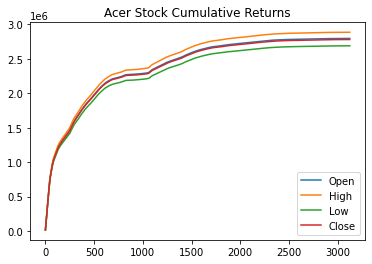

In [35]:
# Cumulative Return
dr = df[imp_col].cumsum()
dr.plot()
plt.title('Acer Stock Cumulative Returns')
plt.show()

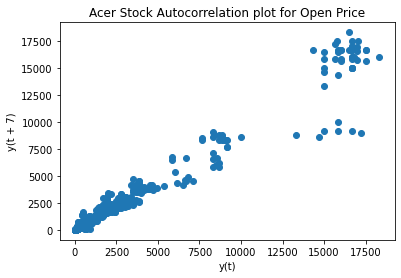

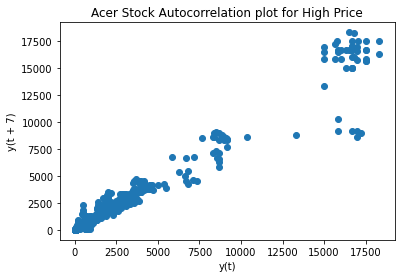

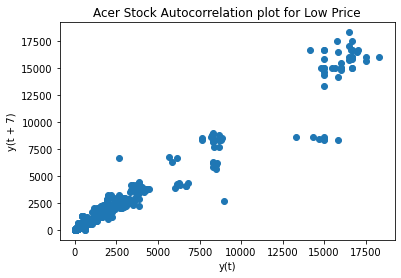

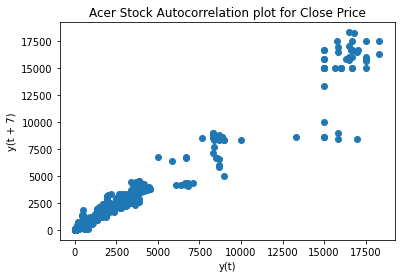

In [36]:
for i in imp_col:
    lag_plot(df[i], lag=7)
    plt.title('Acer Stock Autocorrelation plot for '+i+' Price')
    plt.show()

**SARIMA (Seasonal Auto-Regressive Integrated Moving Average) Model for Time Series Prediction**

In [37]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,17000.00,17000.00,17000.00,17000.00,0,0
1,2005-02-28,16666.67,17500.00,16666.67,17500.00,1,0
2,2005-03-01,16833.33,16833.33,16500.00,16500.00,1,0
3,2005-03-02,15000.00,16333.33,15000.00,15000.00,0,0
4,2005-03-03,15833.33,16833.33,15833.33,16833.33,1,0


In [38]:
#SARIMA works with Date hence original index is set per date
df = df.reset_index()
df = df.set_index('Date')
df.head()

,index,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,,
2005-02-25,0,17000.00,17000.00,17000.00,17000.00,0,0
2005-02-28,1,16666.67,17500.00,16666.67,17500.00,1,0
2005-03-01,2,16833.33,16833.33,16500.00,16500.00,1,0
2005-03-02,3,15000.00,16333.33,15000.00,15000.00,0,0
2005-03-03,4,15833.33,16833.33,15833.33,16833.33,1,0


Opening Price - SARIMA

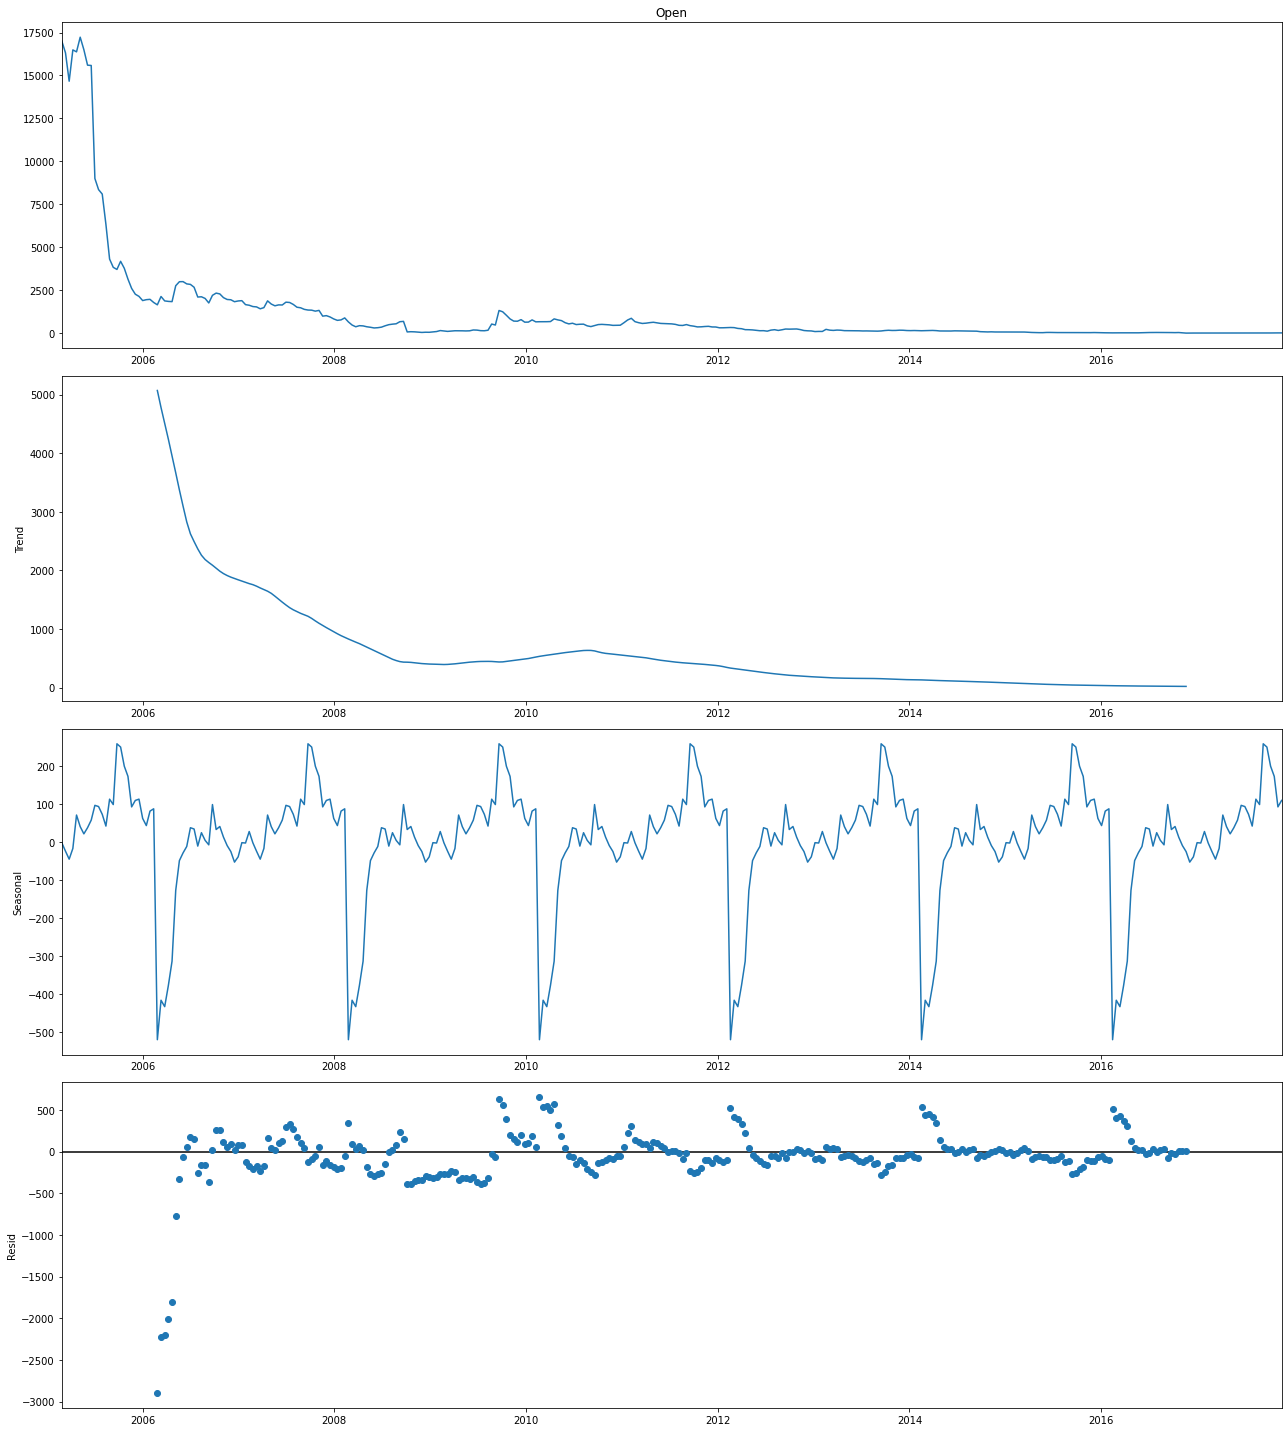

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50982D+00    |proj g|=  1.38672D-01

At iterate    5    f=  6.50150D+00    |proj g|=  8.81387D-03

At iterate   10    f=  6.50015D+00    |proj g|=  3.73251D-02

At iterate   15    f=  6.49804D+00    |proj g|=  2.37123D-02

At iterate   20    f=  6.49775D+00    |proj g|=  5.40176D-03

At iterate   25    f=  6.49765D+00    |proj g|=  1.90088D-02

At iterate   30    f=  6.48752D+00    |proj g|=  3.89272D-01

At iterate   35    f=  6.22444D+00    |proj g|=  1.11939D+00

At iterate   40    f=  6.09129D+00    |proj g|=  1.81428D-02
  ys=-1.077E-02  -gs= 1.428E-03 BFGS update SKIPPED

At iterate   45    f=  6.05758D+00    |proj g|=  4.81030D-01

At iterate   50    f=  6.05334D+00    |proj g|=  1.81929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


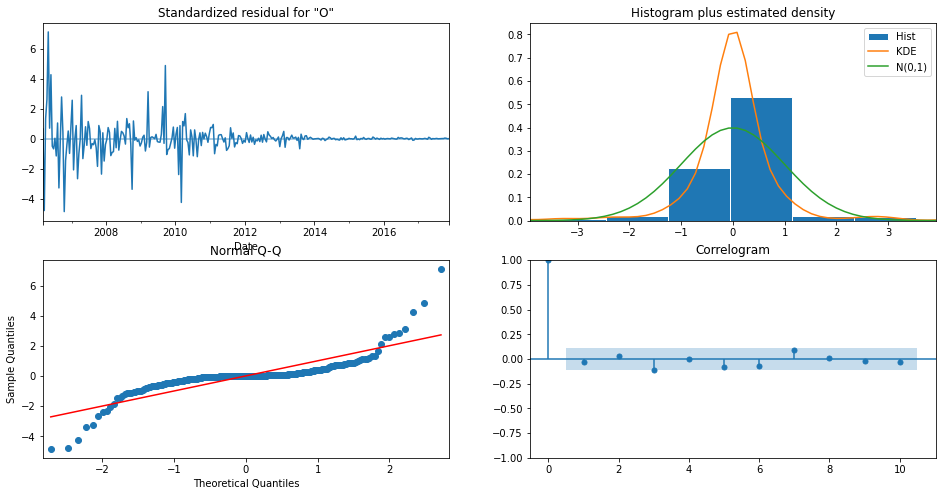

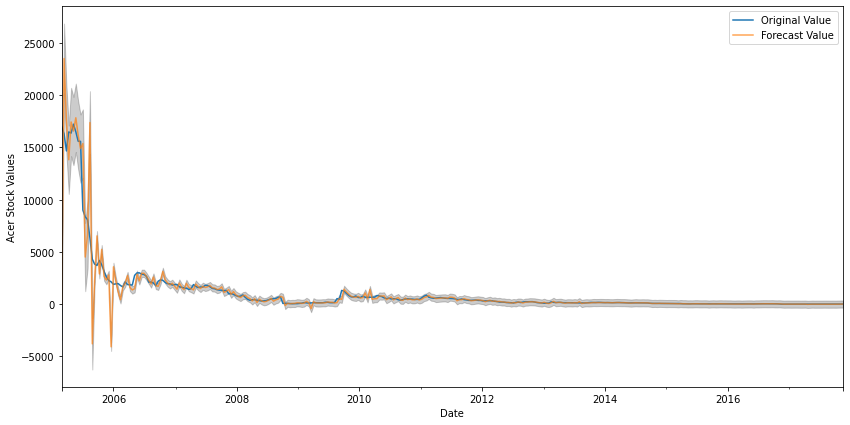

{'mape': inf, 'me': 28.848599316609608, 'mae': 328.68824660899367, 'mpe': inf, 'rmse': 1422.985987871017, 'corr': 0.8820217938138911, 'minmax': 0.22507492369466953}


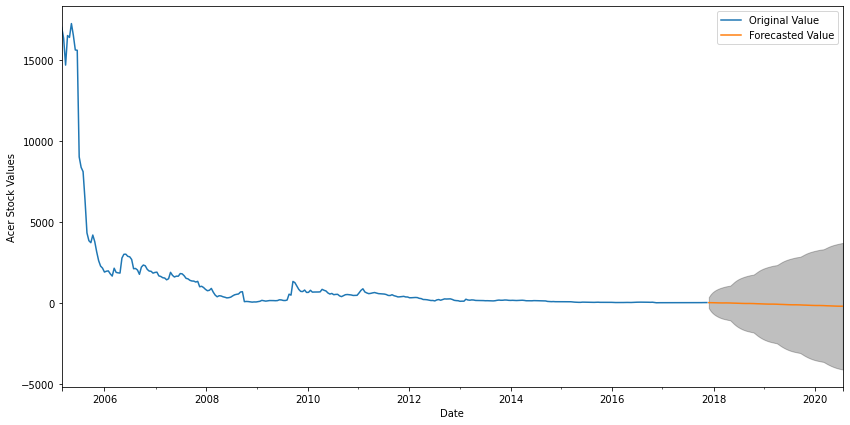

In [39]:
#To avoid NaN tracebacks, 2 weeks data is sampled
t = df['Open'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))


# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

Closing Price - SARIMA

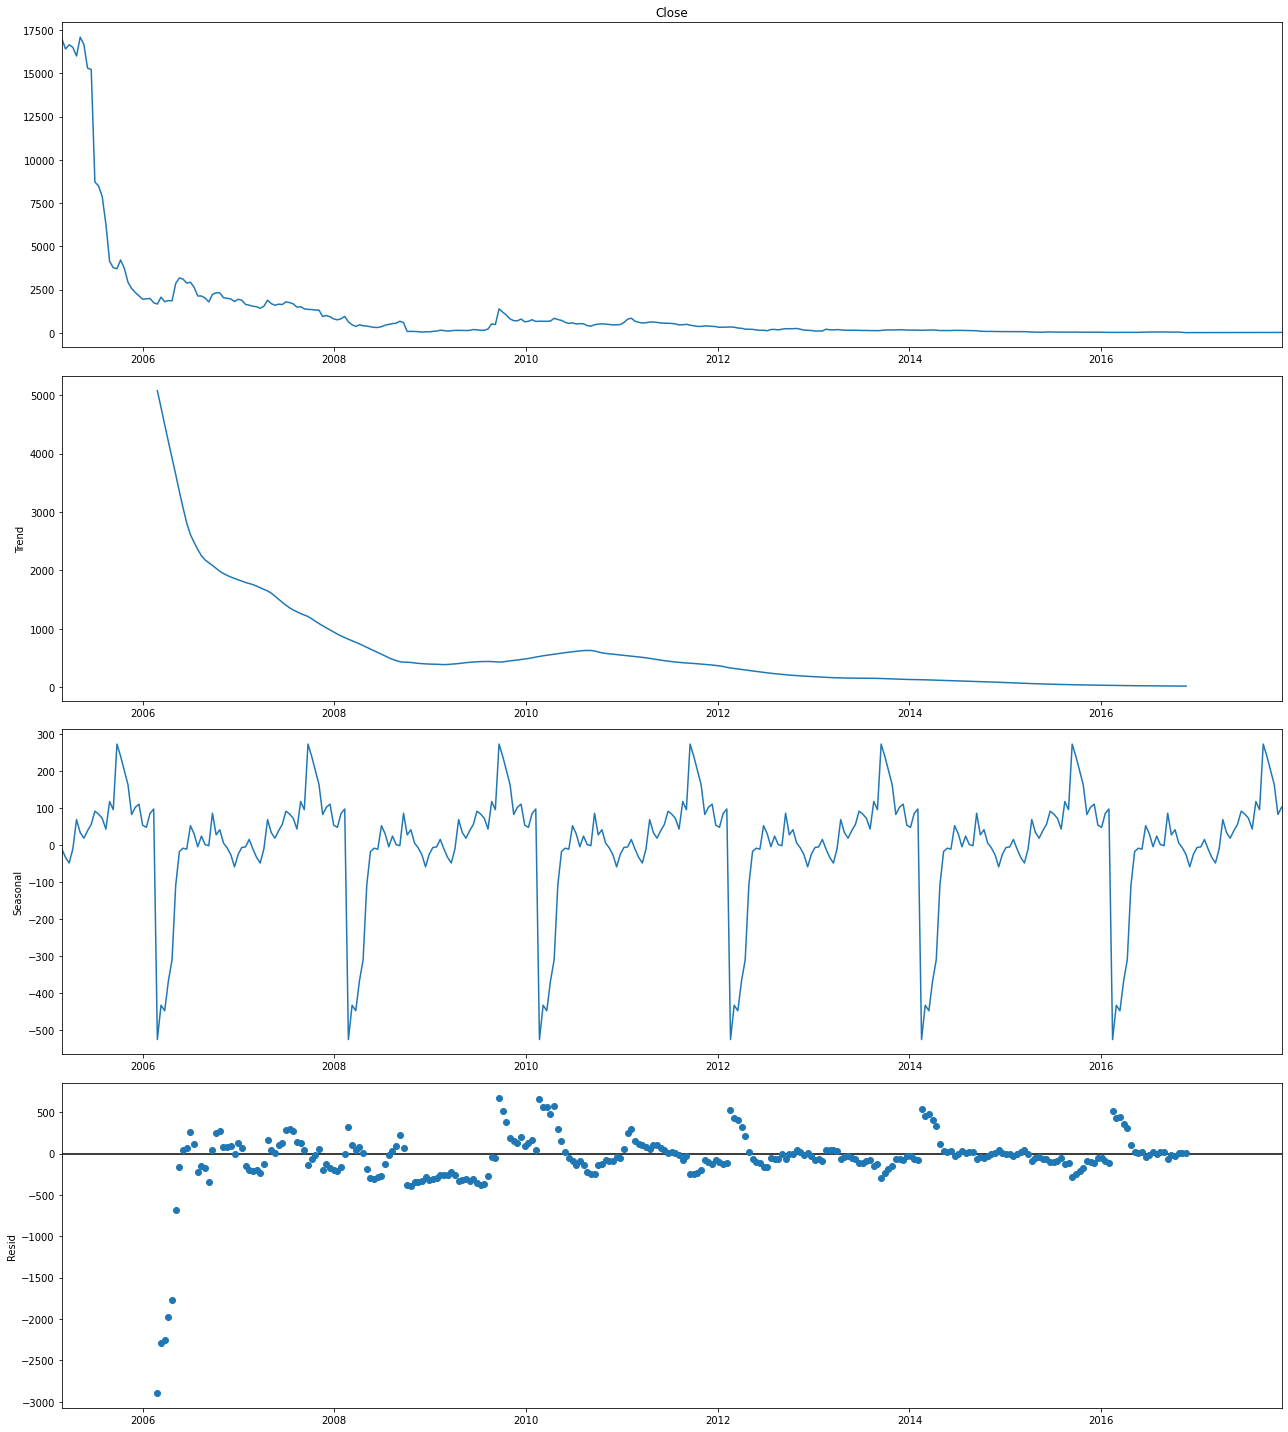

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50808D+00    |proj g|=  4.30745D-02

At iterate    5    f=  6.50441D+00    |proj g|=  2.12262D-03

At iterate   10    f=  6.50356D+00    |proj g|=  4.73411D-02

At iterate   15    f=  6.49951D+00    |proj g|=  1.24046D-01

At iterate   20    f=  6.49836D+00    |proj g|=  1.76708D-03

At iterate   25    f=  6.49794D+00    |proj g|=  3.17023D-02

At iterate   30    f=  6.42206D+00    |proj g|=  5.46021D-01

At iterate   35    f=  6.07369D+00    |proj g|=  2.71298D-01

At iterate   40    f=  6.06573D+00    |proj g|=  8.95928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

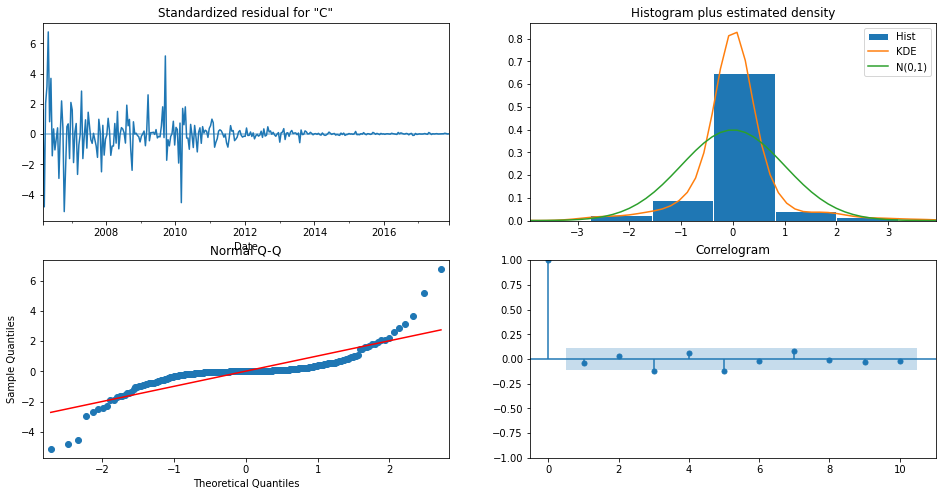

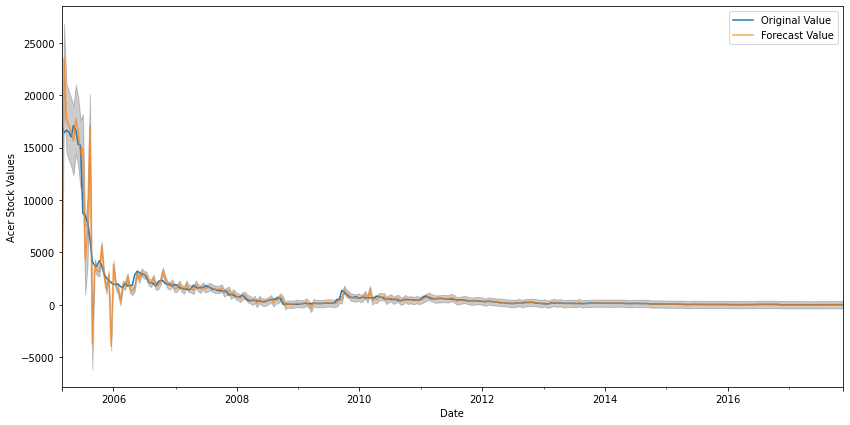

{'mape': inf, 'me': 30.760111801139246, 'mae': 308.3808092932997, 'mpe': inf, 'rmse': 1387.0697537492892, 'corr': 0.8882099833663046, 'minmax': 0.21547102836174803}


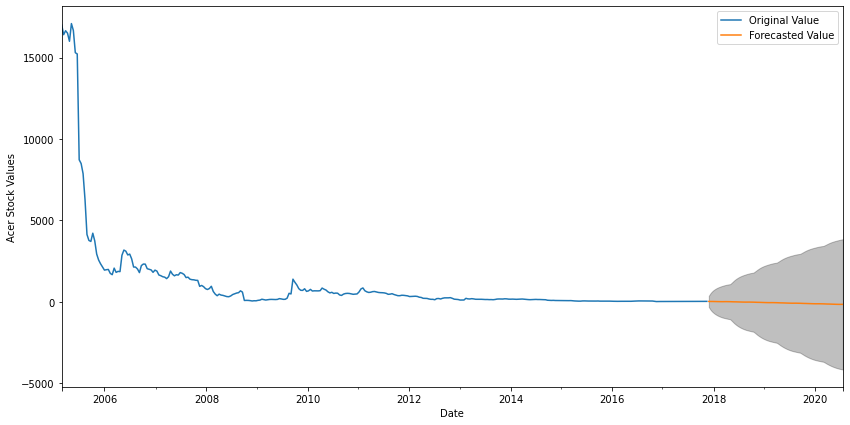

In [40]:
t = df['Close'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))

# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

High Price - SARIMA

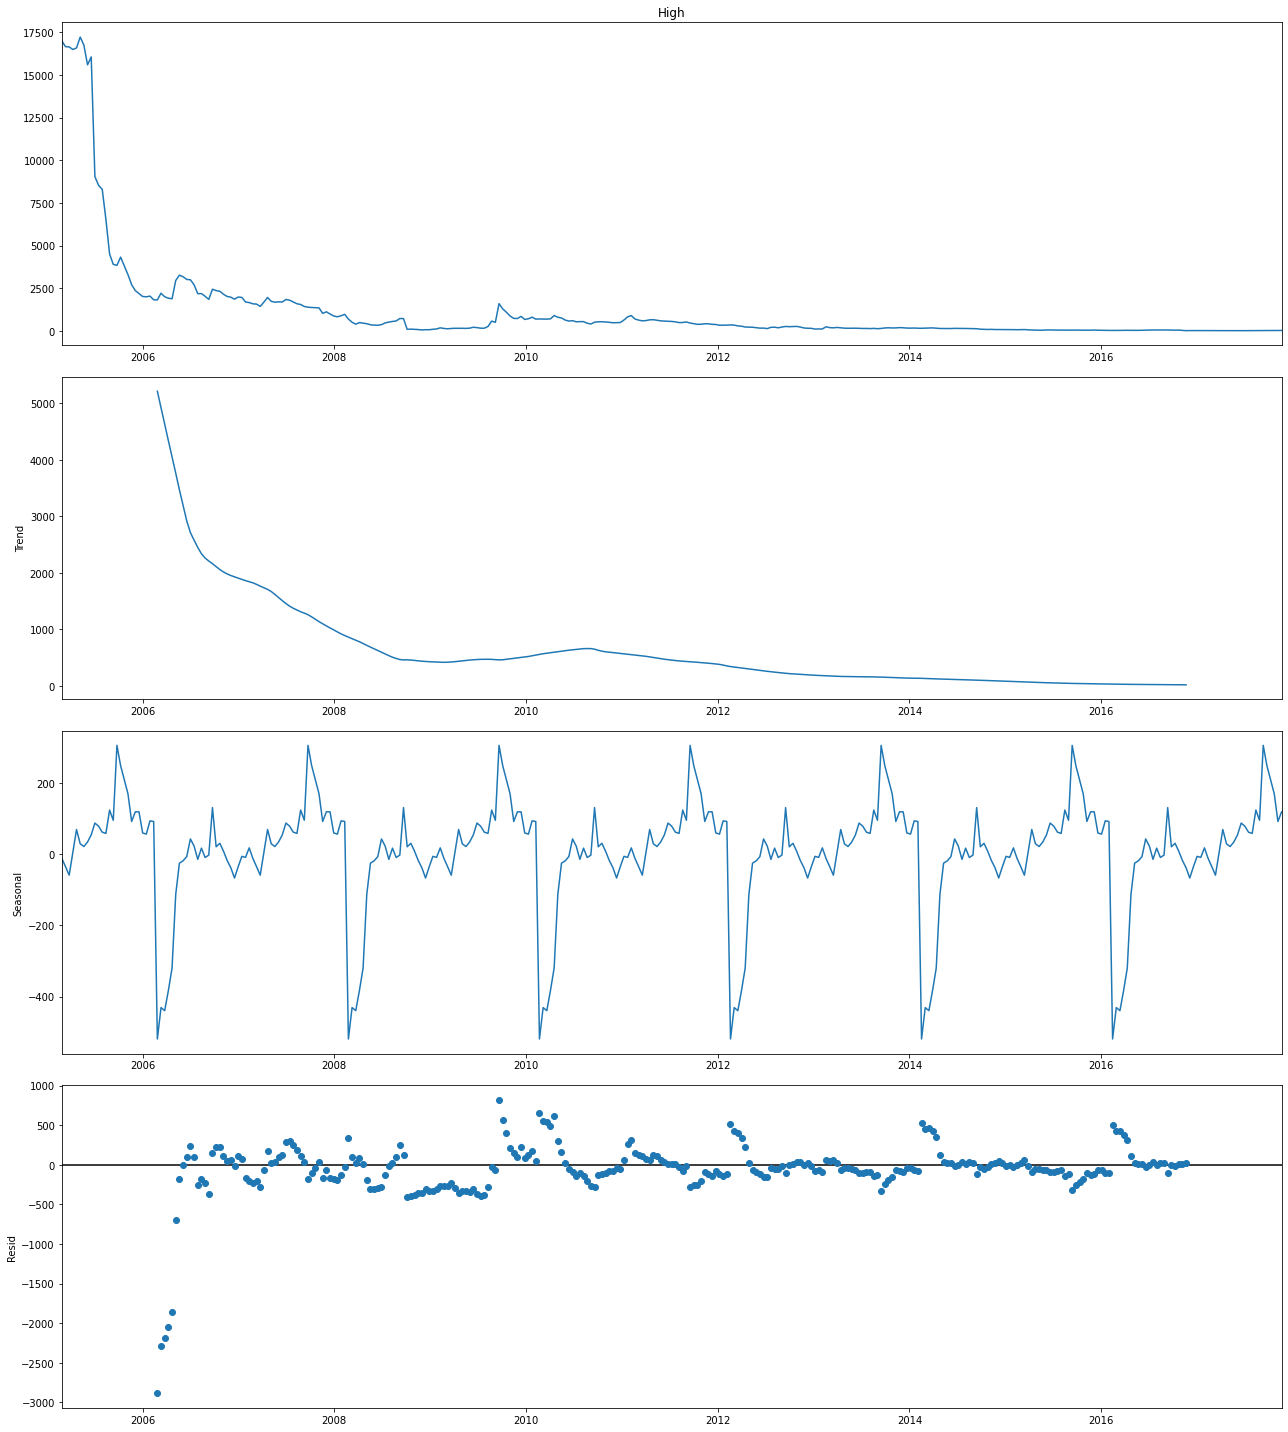

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17283D+00    |proj g|=  3.20496D-01


 This problem is unconstrained.



At iterate    5    f=  6.57144D+00    |proj g|=  6.10584D-02

At iterate   10    f=  6.56728D+00    |proj g|=  5.15479D-02

At iterate   15    f=  6.56504D+00    |proj g|=  6.62647D-03

At iterate   20    f=  6.56494D+00    |proj g|=  2.39554D-02

At iterate   25    f=  6.53612D+00    |proj g|=  6.27418D-01

At iterate   30    f=  6.17297D+00    |proj g|=  3.58762D-01

At iterate   35    f=  6.15786D+00    |proj g|=  5.31126D-01

At iterate   40    f=  6.15089D+00    |proj g|=  1.19284D-02

At iterate   45    f=  6.15089D+00    |proj g|=  1.75917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     71   

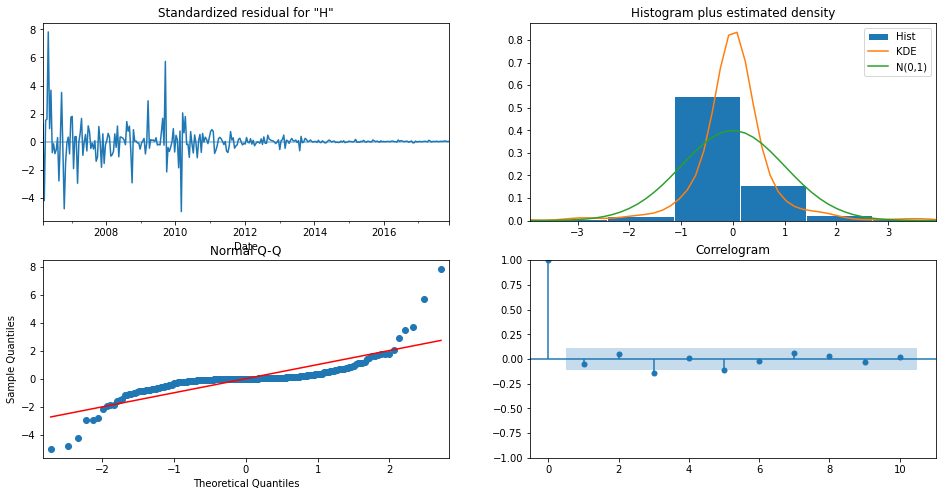

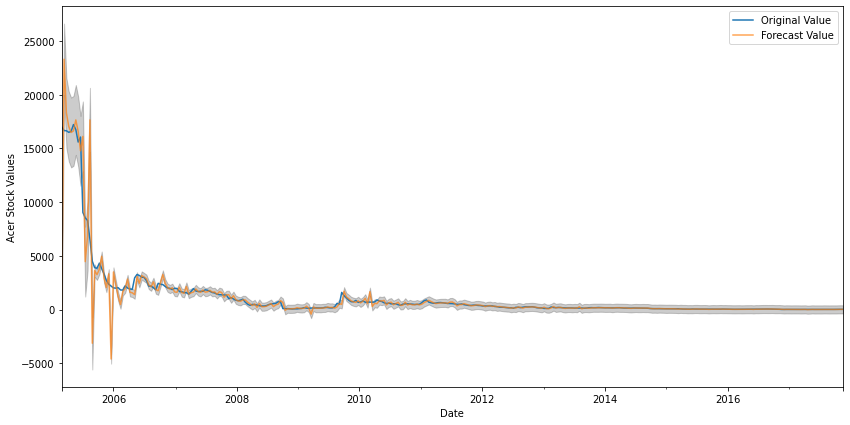

{'mape': inf, 'me': 34.74745744126626, 'mae': 312.8771307549341, 'mpe': inf, 'rmse': 1405.3169146021594, 'corr': 0.8890284890809862, 'minmax': 0.21786137517645465}


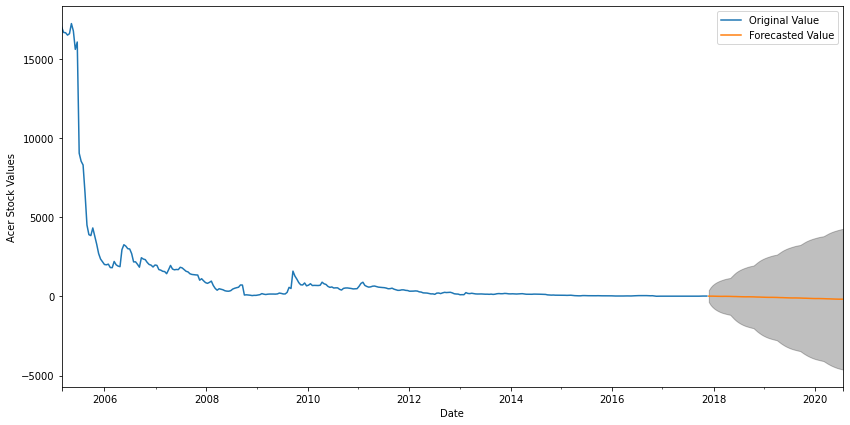

In [41]:
t = df['High'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))

# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

Low Price - SARIMA

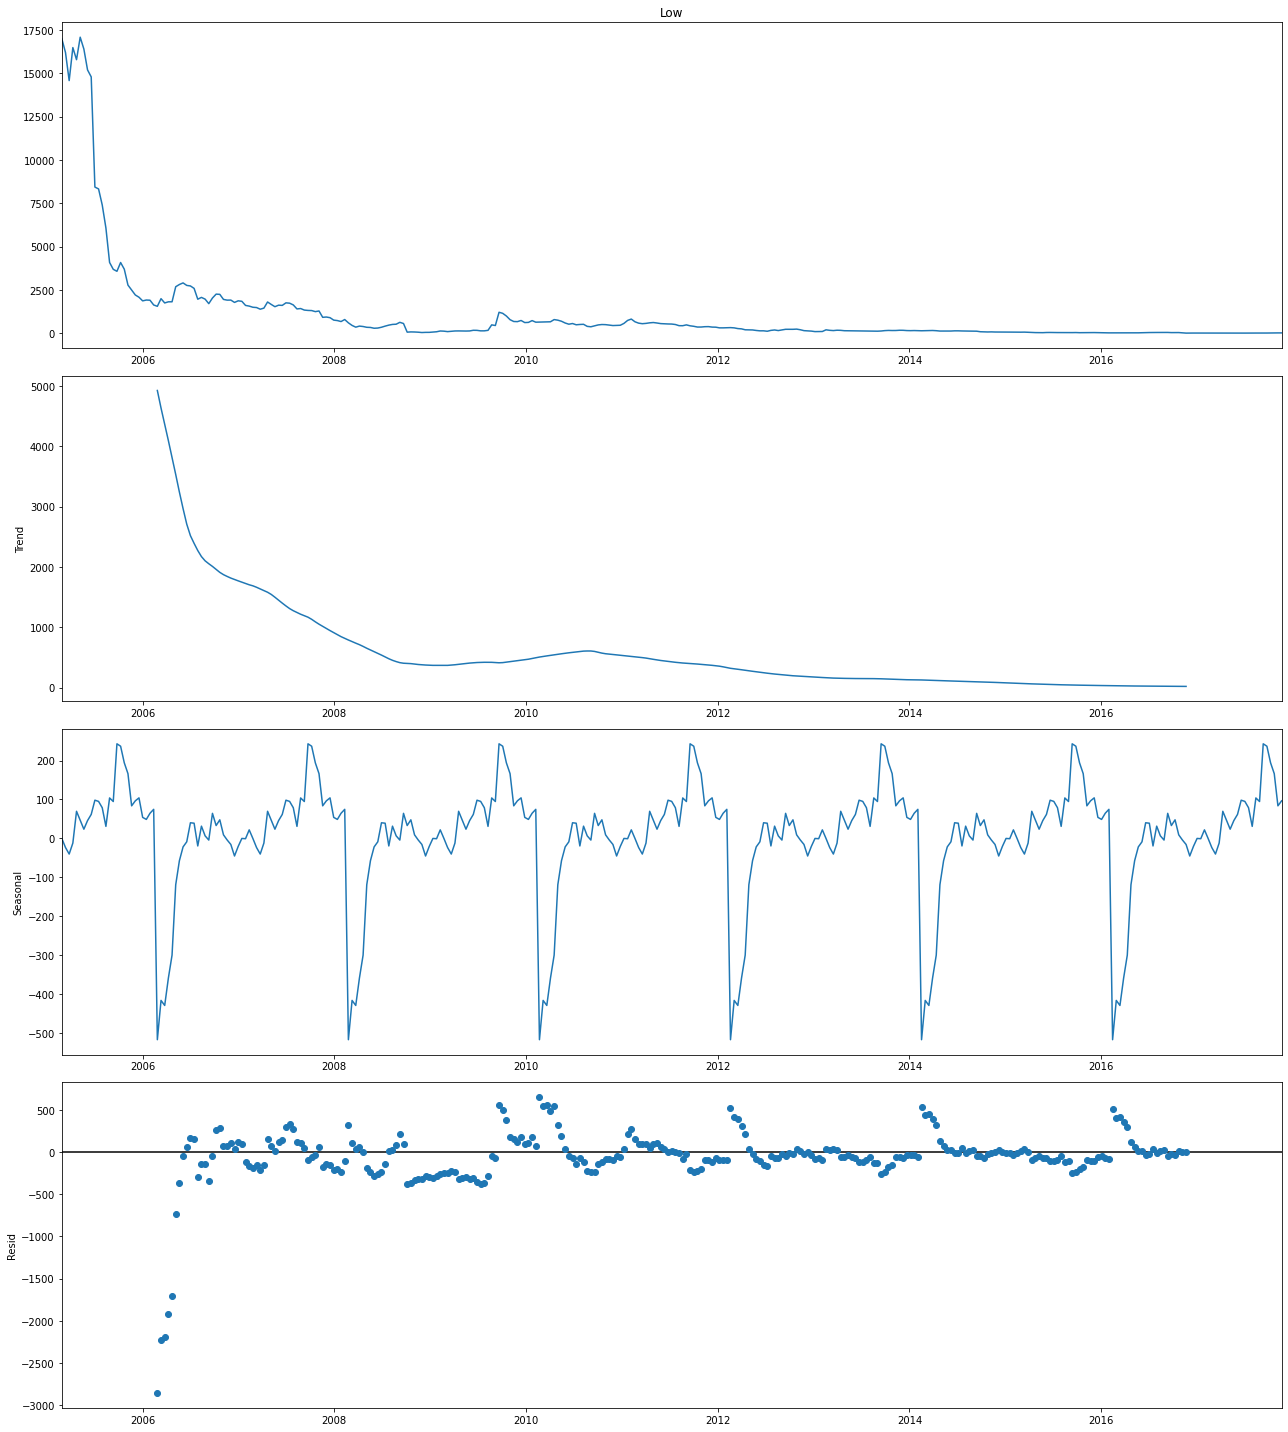

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46726D+00    |proj g|=  5.88606D-02

At iterate    5    f=  6.45747D+00    |proj g|=  1.84116D-03

At iterate   10    f=  6.45417D+00    |proj g|=  7.58150D-02

At iterate   15    f=  6.43389D+00    |proj g|=  1.03937D-01

At iterate   20    f=  6.42422D+00    |proj g|=  8.12863D-02

At iterate   25    f=  6.42132D+00    |proj g|=  4.58359D-02

At iterate   30    f=  6.23016D+00    |proj g|=  8.38327D-01

At iterate   35    f=  6.03624D+00    |proj g|=  1.77239D-01

At iterate   40    f=  6.02586D+00    |proj g|=  1.15339D-01

At iterate   45    f=  6.02231D+00    |proj g|=  7.94058D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

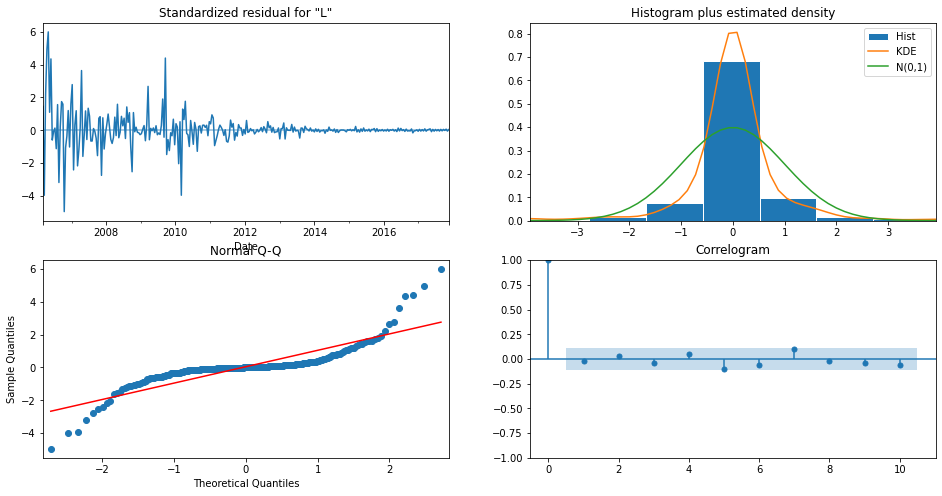

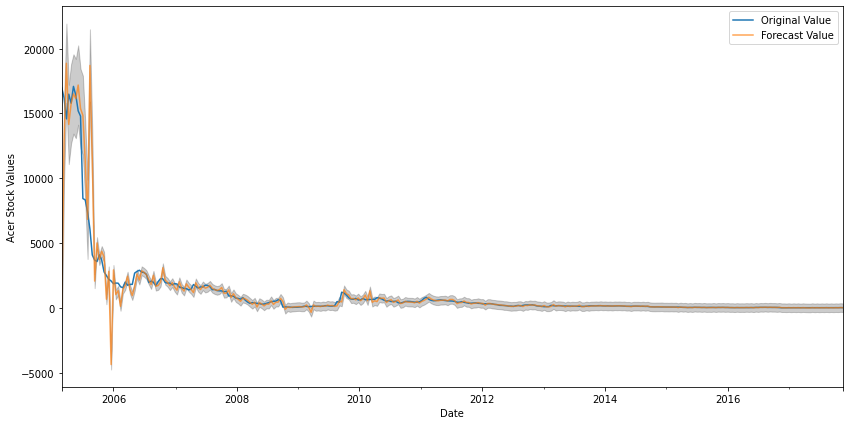

{'mape': inf, 'me': -3.437072108914524, 'mae': 314.66056365599724, 'mpe': inf, 'rmse': 1405.780624709781, 'corr': 0.8776006679312404, 'minmax': 0.2674402706272284}


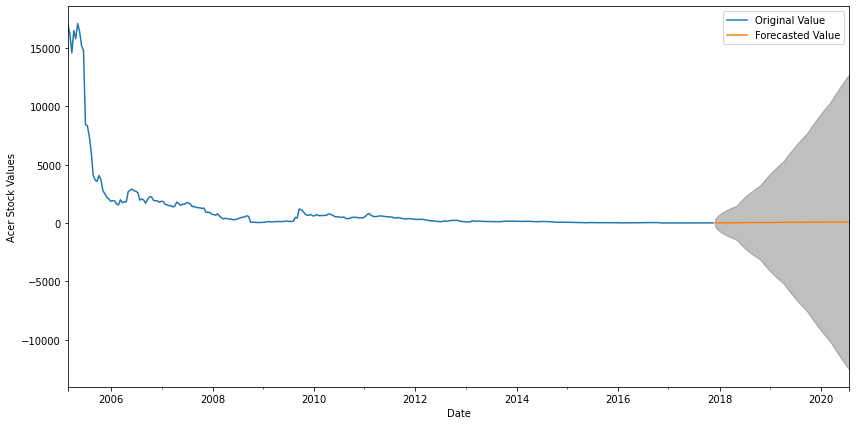

In [42]:
t = df['Low'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))

# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

ARIMA Model for Stock Market Forecasting

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  333
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2485.866
Date:                Sat, 06 Aug 2022   AIC                           4979.733
Time:                        18:19:44   BIC                           4994.953
Sample:                    02-27-2005   HQIC                          4985.803
                         - 11-19-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6735      0.097      6.963      0.000       0.484       0.863
ar.L2          0.1036      0.034      3.067      0.002       0.037       0.170
ma.L1         -0.6360      0.098     -6.502      0.0

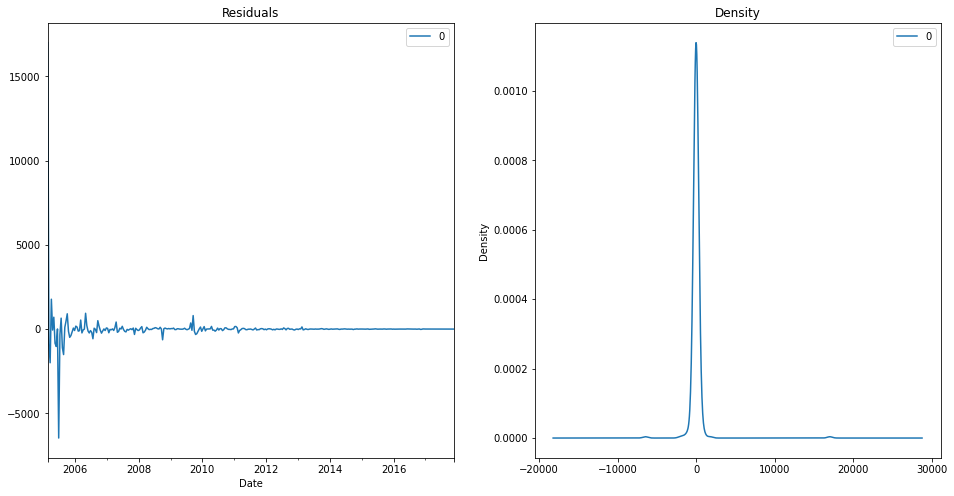

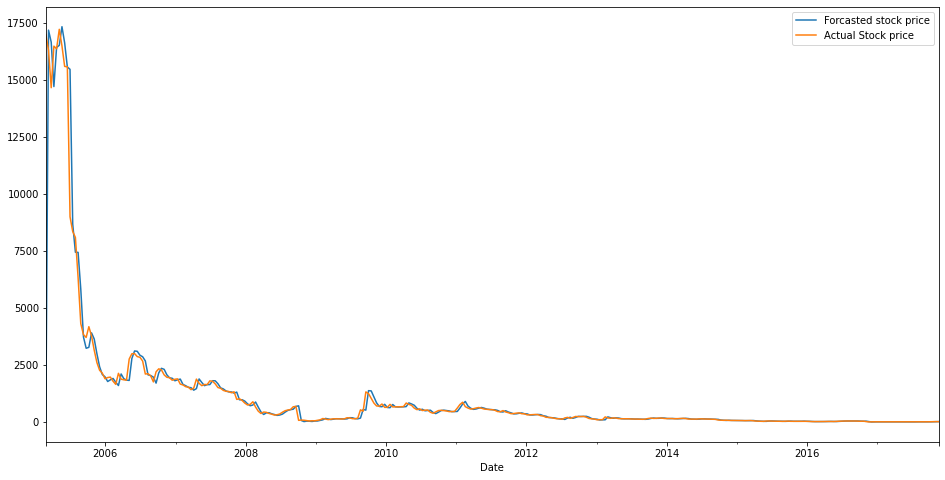

In [49]:
t = df['Open'].resample('2W').mean()

mod = ARIMA(t,order=(2, 1, 1))
results = mod.fit()
print(results.summary())

# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2,figsize=(16, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


# Actual vs Fitted
plt.figure(figsize=(16, 8))
results.predict().plot(label='Forcasted stock price')
t.plot(label='Actual Stock price')
plt.legend()
plt.show()

Forecast Vs Actual

In [43]:
# Forecast
fc, se, conf = results.forecast(70, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc,index = pred_ci.index)
lower_series = pd.Series(conf[:, 0],index = pred_ci.index)
upper_series = pd.Series(conf[:, 1],index = pred_ci.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(t, label='Original Value')
plt.plot(fc_series, label='Predicted Value')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: too many values to unpack (expected 3)